## Table Of Contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Perform EDA](#section-5)
* [Train a Logistic-Regression model using sklearn](#section-6)
* [Evaluate the trained model](#section-7)
* [Save the model to GCS path](#section-8)
* [Create a model with EXplainable-AI(XAI) support in Vertex-AI](#section-9)
* [Cleaning up](#section-10)


## Overview
<a name="section-1"></a>


This example demonstrates building a subscriber churn prediction model on a [Telecom customer churn dataset](https://www.kaggle.com/c/customer-churn-prediction-2020/overview) dataset. The generated churn model is further deployed to Vertex-ai endpoints and explanations are generated using the XAI feature of Vertex-AI within this notebook. 


## Dataset
<a name="section-2"></a>



The dataset itself and an overview of the dataset used in this notebook can be found on the "[Customer Churn Prediction 2020](https://www.kaggle.com/c/customer-churn-prediction-2020/data)" Kaggle competition page. 


## Objective
<a name="section-3"></a>

This notebook demonstrates performing analysis, preprocessing and training a churn prediction model on a tabular churn dataset. The steps performed include the following :

- Load data from a GCS path
- Perform Exploratory Data Analysis(EDA)
- Preprocessing the data
- train an sklearn model
- evaluate the sklearn model
- save the model to a GCS path
- create a model and an endpoint in Vertex-ai
- deploy the trained model to an endpoint
- generate predictions and explanations on test data from the hosted model
- Undeploy the model resource


## Costs 
<a name="section-4"></a>


This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

In [123]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

Install the latest version of the Vertex AI client library.

Run the following command in your virtual environment to install the Vertex SDK for Python:

In [ ]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

Install the Cloud Storage library:

In [ ]:
! pip install {USER_FLAG} --upgrade google-cloud-storage

Install the <b>category_encoders</b> library:

In [ ]:
! pip install --upgrade category_encoders

Install the Seaborn library for the EDA step. If Vertex-ai's managed-instances are being used, this step is optional as the library is already available in the Python3 kernel.

In [ ]:
! pip install --upgrade seaborn

## Before you begin 

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). {TODO: Update the APIs needed for your tutorial. Edit the API names, and update the link to append the API IDs, separating each one with a comma. For example, container.googleapis.com,cloudbuild.googleapis.com}

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


When you create a model in Vertex-AI using the Cloud SDK, you give a Cloud Storage path where the trained model is saved. 
In this tutorial, Vertex AI saves the trained model to a GCS bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
BUCKET_NAME = "gs://[your-bucket-name]"  # @param {type:"string"}
REGION = "[your-region]"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

### Copy dataset into your Cloud Storage bucket

Copy the <b>train.csv</b> file from the "[Customer Churn Prediction 2020](https://www.kaggle.com/c/customer-churn-prediction-2020/data)" Kaggle competition page to the created bucket. In Vertex-ai's managed instances, file upload to a GCS bucket can be performed using the GCS browser pane from the Jupyter Lab environment itself.

## Tutorial

### Import required libraries

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

import joblib
import json
from google.cloud import storage
from google.cloud import aiplatform


## configure to don't display the warnings
import warnings
warnings.filterwarnings("ignore")

### Load data from GCS path using Pandas

In [129]:
df = pd.read_csv("gs://vertex_ai_managed_services_demo/telecom_churn_prediction/train.csv")
print (df.shape)
df.head()

(4250, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


## Perform EDA
<a name="section-5"></a>

Check the datatypes and null counts of the fields


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

Check class imbalance


The current dataset doesn't have any null or empty fields in it.

In [131]:
df['churn'].value_counts(normalize=True)

no     0.859294
yes    0.140706
Name: churn, dtype: float64

There are 14% churners in the data which is not bad for training a churn prediction model. If the class-imablance seems to be high, oversampling or undersampling techniques can be considered to balance the class distribution.

Separate the caetgorical and numerical columns


In [132]:
categ_cols = ['state','area_code', 'international_plan', 'voice_mail_plan']
target = 'churn'
num_cols = [i for i in df.columns if i not in categ_cols and i != target]
print (len(categ_cols), len(num_cols))

4 15


Plot level distribution for the categorical columns


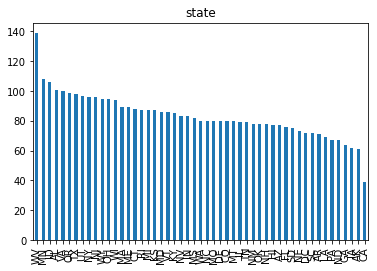

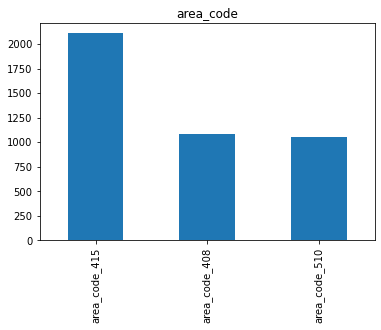

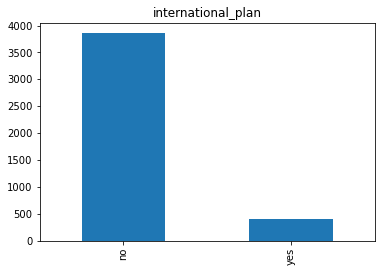

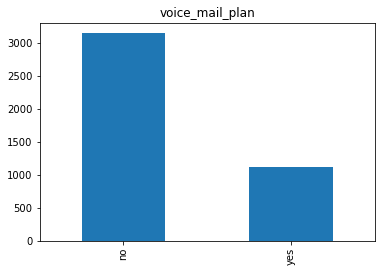

In [133]:
for i in categ_cols : 
    df[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

In [140]:
print (num_cols)
df['number_vmail_messages'].describe()

['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


count    4250.000000
mean        7.631765
std        13.439882
min         0.000000
25%         0.000000
50%         0.000000
75%        16.000000
max        52.000000
Name: number_vmail_messages, dtype: float64

Check distribution for the numerical columns


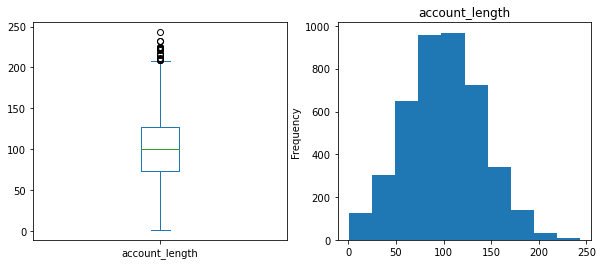

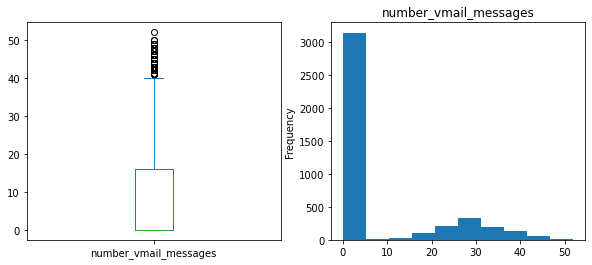

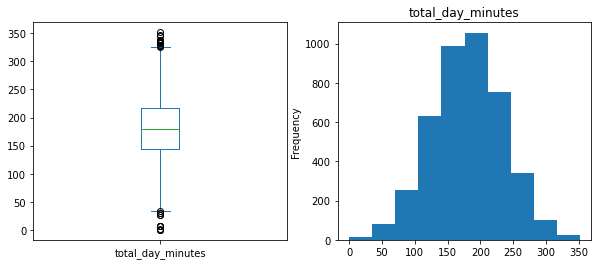

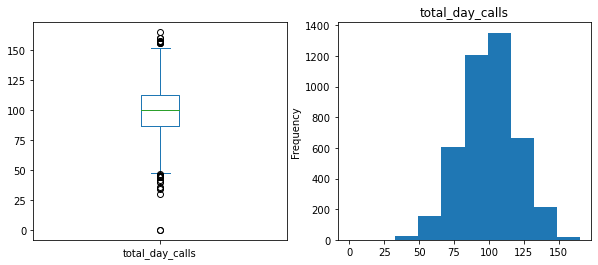

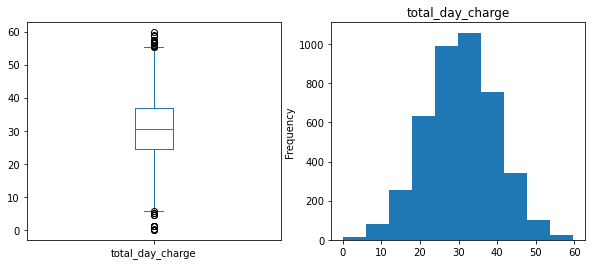

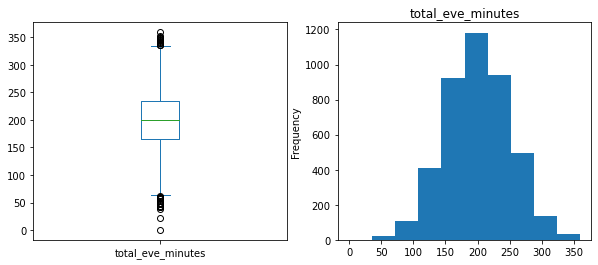

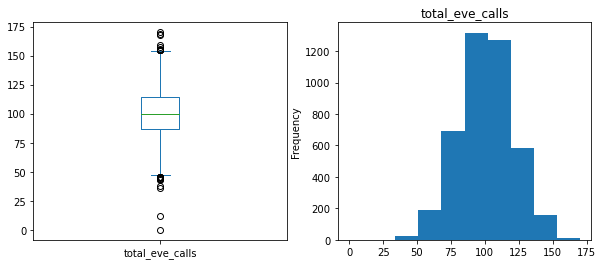

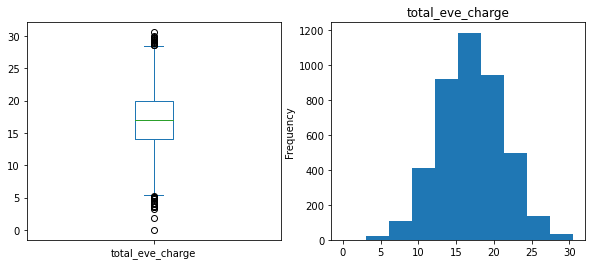

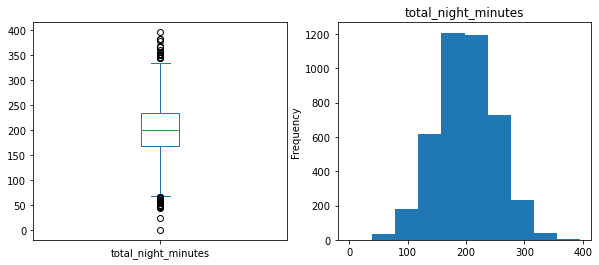

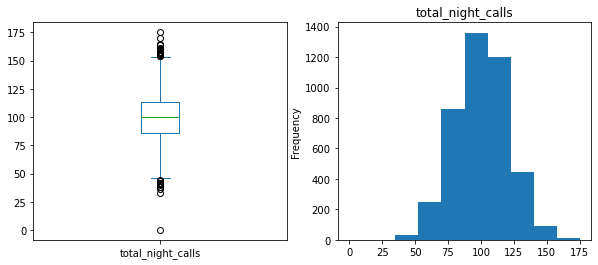

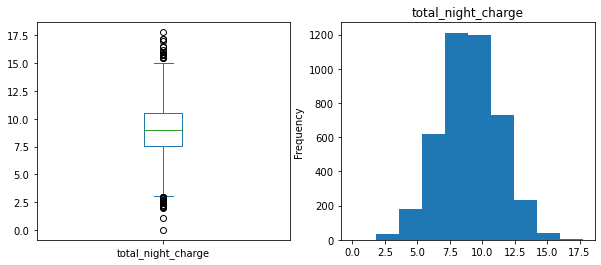

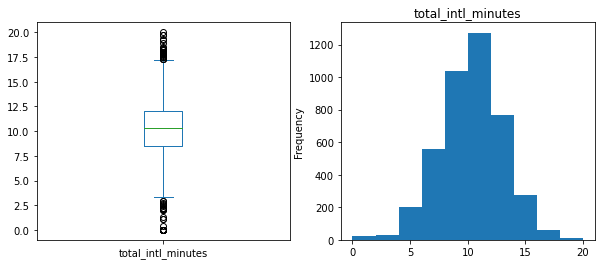

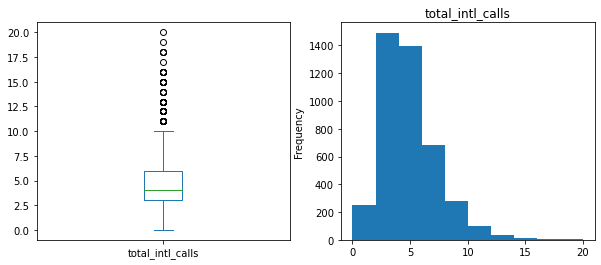

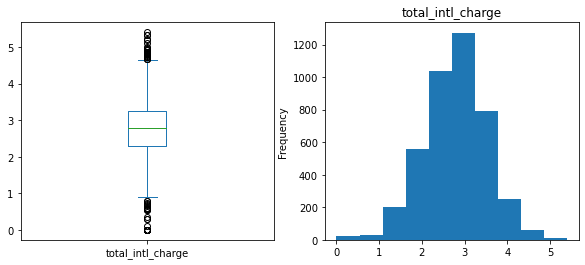

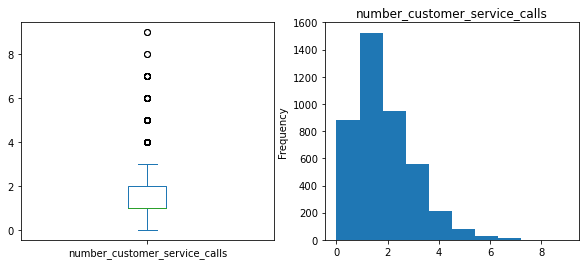

In [134]:
for i in num_cols : 
    ## check the Price field's distribution
    _, ax = plt.subplots(1,2, figsize=(10,4))
    df[i].plot(kind='box',ax=ax[0])
    df[i].plot(kind='hist',ax=ax[1])
    plt.title(i)
    plt.show()

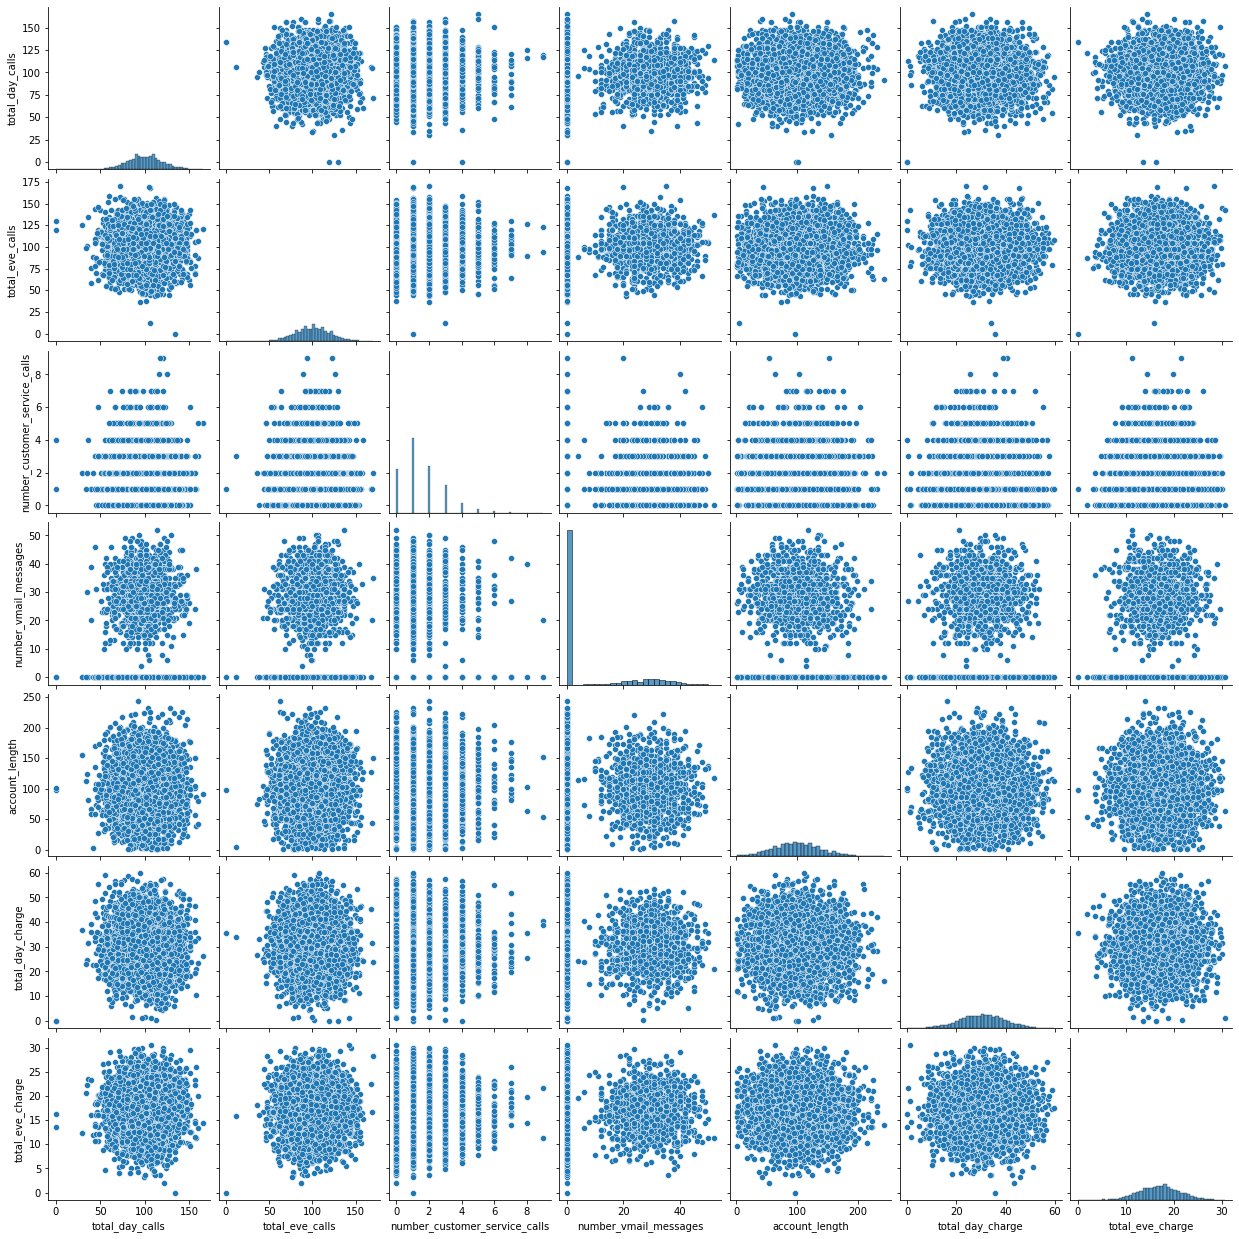

In [135]:
## check pairplots for selected features
selected_features = ['total_day_calls', 'total_eve_calls', 'number_customer_service_calls',
                    'number_vmail_messages','account_length','total_day_charge','total_eve_charge']
sns.pairplot(df[selected_features])
plt.show()

Plot a heatmap of the correlation matrix for the numerical features


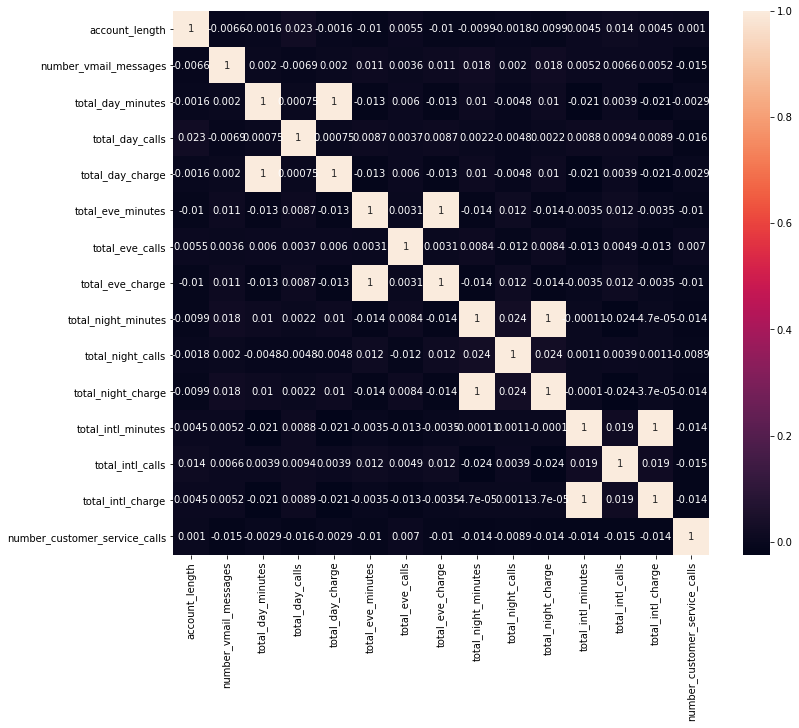

In [9]:
plt.figure(figsize = (12,10))
sns.heatmap(df[num_cols].corr(),annot = True)
plt.show()

### Observations from EDA :

- There are many levels/categories in the categorical field <b>state</b>. In the further steps, creating one hot encoding vector for this field can increase the columns drastically and so binary encoding technique will be considered for encoding this field.
- There are only 9% of customers in the data who have had international plans.
- There are only a few customers who make frequent calls to customer-service.
- Only 25% of the customers had at least 16 vocie-mail messages and thus the skewness in the distribution of "number_vmail_messages" field.
- Most of the feature combinations in the pair plot show a circular pattern that suggests that there is almost no correlation between the corresponding two features.
- There seems to be a high correlation between minutes and charge. Either one of them can be dropped to avoid multi-collinearity or redundant features in the data.

### Preprocess the data

Drop the fields corresponding to the highly correlated features


In [141]:
drop_cols = ['total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
df.drop(columns=drop_cols, inplace=True)
num_cols = list(set(num_cols).difference(set(drop_cols)))
df.shape

(4250, 16)

Binary encode the state feature(as there are many levels/categories)


In [142]:
encoder= ce.BinaryEncoder(cols=['state'],return_df=True)
data_encoded = encoder.fit_transform(df) 
data_encoded.head()

,state_0,state_1,state_2,state_3,state_4,state_5,state_6,account_length,area_code,international_plan,...,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,0,0,0,0,0,0,1,107,area_code_415,no,...,161.6,123,195.5,103,254.4,103,13.7,3,1,no
1,0,0,0,0,0,1,0,137,area_code_415,no,...,243.4,114,121.2,110,162.6,104,12.2,5,0,no
2,0,0,0,0,0,0,1,84,area_code_408,yes,...,299.4,71,61.9,88,196.9,89,6.6,7,2,no
3,0,0,0,0,0,1,1,75,area_code_415,yes,...,166.7,113,148.3,122,186.9,121,10.1,3,3,no
4,0,0,0,0,1,0,0,121,area_code_510,no,...,218.2,88,348.5,108,212.6,118,7.5,7,3,no


One-hot encode(dropping the first level-column to avoid dummy-variable trap scenarios) the remaining categorical variables 


In [143]:
def encode_cols(data, col):
    # Creating a dummy variable for the variable 'CategoryID' and dropping the first one.
    categ = pd.get_dummies(data[col],prefix=col,drop_first=True)
    #Adding the results to the master dataframe
    data = pd.concat([data,categ],axis=1)
    return data

for i in categ_cols + [target]: 
    if i != 'state' :
        data_encoded = encode_cols(data_encoded, i)
        data_encoded.drop(columns=[i], inplace=True)

data_encoded.shape

(4250, 23)

Check the data


In [144]:
data_encoded.head()

,state_0,state_1,state_2,state_3,state_4,state_5,state_6,account_length,number_vmail_messages,total_day_minutes,...,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes,churn_yes
0,0,0,0,0,0,0,1,107,26,161.6,...,254.4,103,13.7,3,1,1,0,0,1,0
1,0,0,0,0,0,1,0,137,0,243.4,...,162.6,104,12.2,5,0,1,0,0,0,0
2,0,0,0,0,0,0,1,84,0,299.4,...,196.9,89,6.6,7,2,0,0,1,0,0
3,0,0,0,0,0,1,1,75,0,166.7,...,186.9,121,10.1,3,3,1,0,1,0,0
4,0,0,0,0,1,0,0,121,24,218.2,...,212.6,118,7.5,7,3,0,1,0,1,0


Check the columns


In [145]:
data_encoded.columns

Index(['state_0', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'account_length', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_eve_minutes',
       'total_eve_calls', 'total_night_minutes', 'total_night_calls',
       'total_intl_minutes', 'total_intl_calls',
       'number_customer_service_calls', 'area_code_area_code_415',
       'area_code_area_code_510', 'international_plan_yes',
       'voice_mail_plan_yes', 'churn_yes'],
      dtype='object')

Split the data into train-test


In [146]:
X = data_encoded[[i for i in data_encoded.columns if i not in ['churn_yes']]].copy()
y = data_encoded['churn_yes'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)
print (X_train.shape, X_test.shape)

(2975, 22) (1275, 22)


Scale the numerical data using MinMaxScaler


In [147]:
sc = MinMaxScaler()
X_train.loc[:,num_cols] = sc.fit_transform(X_train[num_cols])
X_test.loc[:, num_cols] = sc.transform(X_test[num_cols])

## Train a Logistic-Regression model using sklearn
<a name="section-6"></a>

Argument class_weight adjusts the class weights to the target feature


In [148]:
model = LogisticRegression(class_weight="balanced") 
model = model.fit(X_train, y_train)

## Evaluate the trained model
<a name="section-7"></a>

#### Plot the ROC and show AUC on train and test sets

Plot the ROC for the model on train data


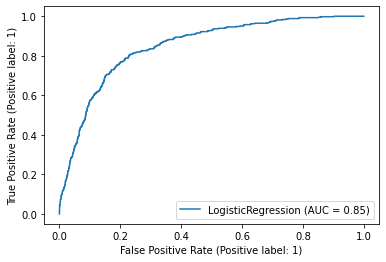

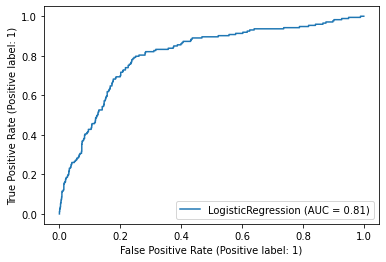

In [149]:
plot_roc_curve(model, X_train, y_train, drop_intermediate=False)
plt.show()

## plot the ROC for the model on test data
plot_roc_curve(model, X_test, y_test, drop_intermediate=False)
plt.show()

#### Determine the optimal threhsold for the binary classification 

In general, the logistic regression model outputs probability scores between 0 and 1 and a threshold needs to be determined to assign a class-label. Depending on the sensitivity(True-positive rate) and specificity(True-negative rate) of the model, an optimal thresold can be  determined.

Create columns with 10 different probability cutoffs 


In [151]:
y_train_pred = model.predict_proba(X_train)[:,1]
numbers = [float(x)/10 for x in range(10)]
y_train_pred_df = pd.DataFrame({'true':y_train, 'pred':y_train_pred})
for i in numbers:
    y_train_pred_df[i]= y_train_pred_df.pred.map(lambda x: 1 if x > i else 0)

Now calculate accuracy sensitivity and specificity for various probability cutoffs.


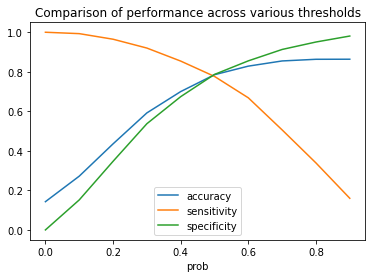

In [152]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])

# compute the parameters for each threshold considered
for i in numbers:
    cm1 = confusion_matrix( y_train_pred_df.true, y_train_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [ i ,accuracy,sensi,speci]
    
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.title('Comparison of performance across various thresholds')
plt.show()

In general, a model with balanced sensitivity and specificity is preferred. In the current case, the threshold where the sensitivity and specifity curves intersect can be considered as an optimal threshold.

In [153]:
threshold = 0.5

# Evaluate train and test sets
y_test_pred = model.predict_proba(X_test)[:,1]

# to get the performance stats, lets define a handy function
def print_stats(y_true, y_pred) :
    # Confusion matrix 
    confusion = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print ('Confusion Matrix: ')
    print (confusion)
    
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # Let's see the sensitivity or recall of our logistic regression model
    sensitivity = TP / float(TP+FN)
    print ('sensitivity = ', sensitivity)
    # Let us calculate specificity
    specificity = TN / float(TN+FP)
    print ('specificity = ', specificity)
    # Calculate false postive rate - predicting conversion when customer didn't convert
    fpr = FP/ float(TN+FP)
    print ('False positive rate = ', fpr)
    # positive predictive value 
    precision = TP / float(TP+FP)
    print ('precision = ', precision)
    ## accuracy
    accuracy = (TP + TN)/(TP+TN+FP+FN)
    print ('accuracy = ', accuracy)
    return

y_train_pred_sm = [1 if i > threshold else 0 for i in y_train_pred]
y_test_pred_sm = [1 if i > threshold else 0 for i in y_test_pred]
### Print the metrics for the model
## on train data
print("Train Data : ")
print_stats(y_train, y_train_pred_sm)
print ("\n","*"*30,"\n")
## on test data
print("Test Data : ")
print_stats(y_test, y_test_pred_sm)

Train Data : 
Confusion Matrix: 
[[2006  544]
 [  95  330]]
sensitivity =  0.7764705882352941
specificity =  0.7866666666666666
False positive rate =  0.21333333333333335
precision =  0.37757437070938216
accuracy =  0.7852100840336135

 ****************************** 

Test Data : 
Confusion Matrix: 
[[845 257]
 [ 42 131]]
sensitivity =  0.7572254335260116
specificity =  0.7667876588021778
False positive rate =  0.23321234119782214
precision =  0.33762886597938147
accuracy =  0.7654901960784314


While the model's sensitivity and specificity are looking decent, the precision can be identified to be low. This type of situation is generally acceptable to some extent because from a business standpoint in Telecom industry, it still makes sense to identify churners even though it means there'd be some mis-classifications of non-churner as a churner.

## Save the model to GCS path
<a name="section-8"></a>

Save the trained model to a local file "model.joblib"


In [156]:
FILE_NAME = "model.joblib"
joblib.dump(model, FILE_NAME)

# Upload the saved model file to GCS
BUCKET_NAME = "your bucket name"
BLOB_PATH = "path to save the model" ## leave blank if no folders inside the bucket are needed.


BLOB_NAME = BLOB_PATH + FILE_NAME

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename("model.joblib")

## Create a model with EXplainable-AI(XAI) support in Vertex-AI
<a name="section-9"></a>

Before creating a model, configure the explanations for the model so that deployed model. For further details, please refer [Configuring-Explanations in Vertex-AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations#scikit-learn-and-xgboost-pre-built-containers).

In [169]:
REGION = "us-central1"
MODEL_DISPLAY_NAME = "your model display name
ARTIFACT_GCS_PATH = f'gs://{BUCKET_NAME}/{BLOB_PATH}'

## Feature-name(Inp_feature) and Output-name(Model_output) can be arbitrary
exp_metadata = {
  "inputs": {
    "Inp_feature": {
    }
  },
  "outputs": {
    "Model_output": {
    }
  }
}

with open("explanation-metadata.json","w") as fp:
    json.dump(exp_metadata, fp)

In [171]:
! gcloud beta ai models upload \
  --region=$REGION \
  --display-name=$MODEL_DISPLAY_NAME \
  --container-image-uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest" \
  --artifact-uri=$ARTIFACT_GCS_PATH \
  --explanation-method=sampled-shapley \
  --explanation-path-count=25 \
  --explanation-metadata-file=explanation-metadata.json

E0928 12:54:29.674942871    1913 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1632833669.674763158","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1632833669.674720274","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":957,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [696221482946134016]...done.                             


Get the MODEL_ID from the created model.

In [172]:
! gcloud beta ai models list \
  --region $REGION \
  --filter=display_name=$MODEL_DISPLAY_NAME

E0928 12:59:19.675006749    1935 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1632833959.674803616","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1632833959.674794127","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":957,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
MODEL_ID           DISPLAY_NAME
80985628455469056  subsc-churn-model


In [173]:
MODEL_ID = "80985628455469056"

### Create an Endpoint

In [174]:
ENDPOINT_DISPLAY_NAME = "your endpoint display name"

In [175]:
! gcloud beta ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2916496099239788544]...done.                            
Created Vertex AI endpoint: projects/931647533046/locations/us-central1/endpoints/5945296865896431616.


Verify that the endpoint has been created and save the ENDPOINT_ID.

In [176]:
! gcloud beta ai endpoints list \
  --region=$REGION \
  --filter=display_name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
5945296865896431616  subsc-churn-model-ep1


In [177]:
ENDPOINT_ID = "5945296865896431616"

### Deploy the model to the created endpoint

Configure the depoyment name, machine-type and other parameters for the deployment.

In [178]:
DEPLOYED_MODEL_NAME = "deployment model name"
MACHINE_TYPE = "n1-standard-4"

In [179]:
! gcloud beta ai endpoints deploy-model $ENDPOINT_ID\
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$DEPLOYED_MODEL_NAME \
  --machine-type=$MACHINE_TYPE \
  --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2182409359978397696]...done.                            
Deployed a model to the endpoint 5945296865896431616. Id of the deployed model: 514333947287568384.


In [217]:
## Save the ID of the deployed model
DEPLOYED_MODEL_ID = "514333947287568384"

### Get Explanations from the deployed model

Get Explanations for some test instances from the hosted model.

In [180]:
## format the top 2 test instances as the request's payload
test_json = {"instances" : [X_test.iloc[0].tolist(), 
                            X_test.iloc[1].tolist()]}
with open("request.json","w") as fp:
    json.dump(test_json, fp)

In [181]:
! gcloud beta ai endpoints explain $ENDPOINT_ID \
  --region=$REGION \
  --json-request=request.json

E0928 13:21:29.675062179    2018 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1632835289.674798212","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1632835289.674777689","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":957,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
Deployed model id to be used for explanation: 514333947287568384
{
  "deployedModelId": "514333947287568384",
  "explanations": [
    {
      "attributions": [
        {
          "approximationError": 0.0026408602142018703,
          "featureAttributions": {
            "Inp_feature": [
              0,
              0,
              -0.08,
              0,
              0,
              0,
              0,
              0,
              0,
              0.28,
           

### Plot the feature attributions from the Explanations

##########Explanations##########
 explanation
  attribution
   baseline_output_value: 0.0
   instance_output_value: 1.0
   output_display_name: 
   approximation_error: 0.0026408602142018703
   output_name: Model_output
   output_index: -1


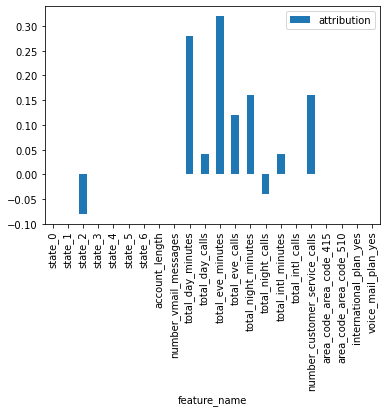

 explanation
  attribution
   baseline_output_value: 0.0
   instance_output_value: 0.0
   output_display_name: 
   approximation_error: 0.0
   output_name: Model_output
   output_index: -1


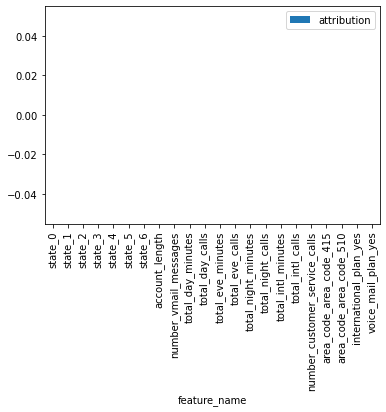

##########Predictions##########
1.0
0.0


In [209]:
features = X_train.columns.to_list()

def plot_attributions(attrs):
    '''
    Function to plot the features and their attributions for an instance
    '''
    rows = {"feature_name":[], "attribution":[]}
    for i, val in enumerate(features) :
        rows["feature_name"].append(val)
        rows["attribution"].append(attrs["Inp_feature"][i])
    attr_df = pd.DataFrame(rows).set_index("feature_name")
    attr_df.plot(kind="bar")
    plt.show()
    return

def explain_tabular_sample(project: str, location: str, endpoint_id: str, instances:list ):
    '''
    Function to make an explanation request for the specified payload and generate feature attribution plots
    '''
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint_id)

    response = endpoint.explain(instances=instances)
    print ("#"*10 + "Explanations" + "#"*10)
    for explanation in response.explanations:
        print(" explanation")
        # Feature attributions.
        attributions = explanation.attributions
        
        for attribution in attributions:
            print("  attribution")
            print("   baseline_output_value:", attribution.baseline_output_value)
            print("   instance_output_value:", attribution.instance_output_value)
            print("   output_display_name:", attribution.output_display_name)
            print("   approximation_error:", attribution.approximation_error)
            print("   output_name:", attribution.output_name)
            output_index = attribution.output_index
            for output_index in output_index:
                print("   output_index:", output_index)
                
            plot_attributions(attribution.feature_attributions)
            
    print ("#"*10 + "Predictions" + "#"*10)
    for prediction in response.predictions:
        print(prediction)
        
    return response

test_json = [X_test.iloc[0].tolist(), X_test.iloc[1].tolist()]
prediction = explain_tabular_sample("vertex-ai-dev", REGION, ENDPOINT_ID, test_json)

## Cleaning up
<a name="section-10"></a>

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [218]:
# Undeploy the model resource
! gcloud ai endpoints undeploy-model $ENDPOINT_ID --deployed-model-id=$DEPLOYED_MODEL_ID --quiet --region=$REGION

# Delete endpoint resource
! gcloud ai endpoints delete $ENDPOINT_ID --quiet --region=$REGION

# Delete model resource
! gcloud ai models delete $MODEL_ID --quiet --region=$REGION

# Delete Cloud Storage objects that were created
# gsutil -m rm -r $BUCKET_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
